In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# offsets of each variable in the state Vector
iDx = 0
iDy = 1
iVx = 2
iVy = 3
numvars = max(iDx,iDy,iVx,iVy) + 1

class KF:
    def __init__(self, initial_x, 
                       initial_v,
                       accel_variance) -> None:
        
        # mean of state GRV
        self._x = np.zeros(numvars).reshape(numvars,1) # 4x1 matrix
        self._x[iDx] = initial_x[0]
        self._x[iDy] = initial_x[1]
        self._x[iVx] = initial_v[0]
        self._x[iVy] = initial_v[1]
        
        
        self._accel_variance = np.array([[accel_variance,0],[0,accel_variance]]) # 2x2 matrix

        # covariance of state GRV
        self._P = np.eye(numvars)  # 4x4 identity matrix
        

    def predict(self, dt: float) -> None:
        # x = F x
        # P = F P Ft + G a Gt
        F = np.eye(numvars) # 4x4 state transition matrix
        F[iDx,iVx] = dt
        F[iDy,iVy] = dt
        '''
        F = array([[1., 0., 1., 0.],
                   [0., 1., 0., 1.],
                   [0., 0., 1., 0.],
                   [0., 0., 0., 1.]])
        '''
        # x = F x   
        # new state as per the state transition matrix
        new_x = F.dot(self._x)
        
        
        G = np.zeros((4,2)) 
        G[iDx,iDx] =G[iDy,iDy] = dt**2/2
        G[iVx,iDx]= G[iVy,iDy] = dt

        new_P = F.dot(self._P).dot(F.T) + G.dot(self._accel_variance).dot(G.T)

        self._P = new_P
        self._x = new_x

    def update(self, meas_value, meas_variance):
        # y = z - H x
        # S = H P Ht + R
        # K = P Ht S^-1
        # x = x + K y
        # P = (I - K H) * P

        H = np.concatenate((np.eye(2),np.zeros((2,2))),axis=1)

        z = meas_value #2x1 [[mDx],[mDy]]
        R = meas_variance #2x2 [[sigma_x^2, 0], [0, sigma_y^2]]

        y = z - H.dot(self._x)
        S = H.dot(self._P).dot(H.T) + R

        K = self._P.dot(H.T).dot(np.linalg.inv(S))

        new_x = self._x + K.dot(y)
        new_P = (np.eye(4) - K.dot(H)).dot(self._P)

        self._P = new_P
        self._x = new_x

    @property
    def cov(self) -> np.array:
        return self._P

    @property
    def mean(self) -> np.array:
        return self._x

    @property
    def pos(self) -> float:
        return self._x[iX]

    @property
    def vel(self) -> float:
        return self._x[iV]




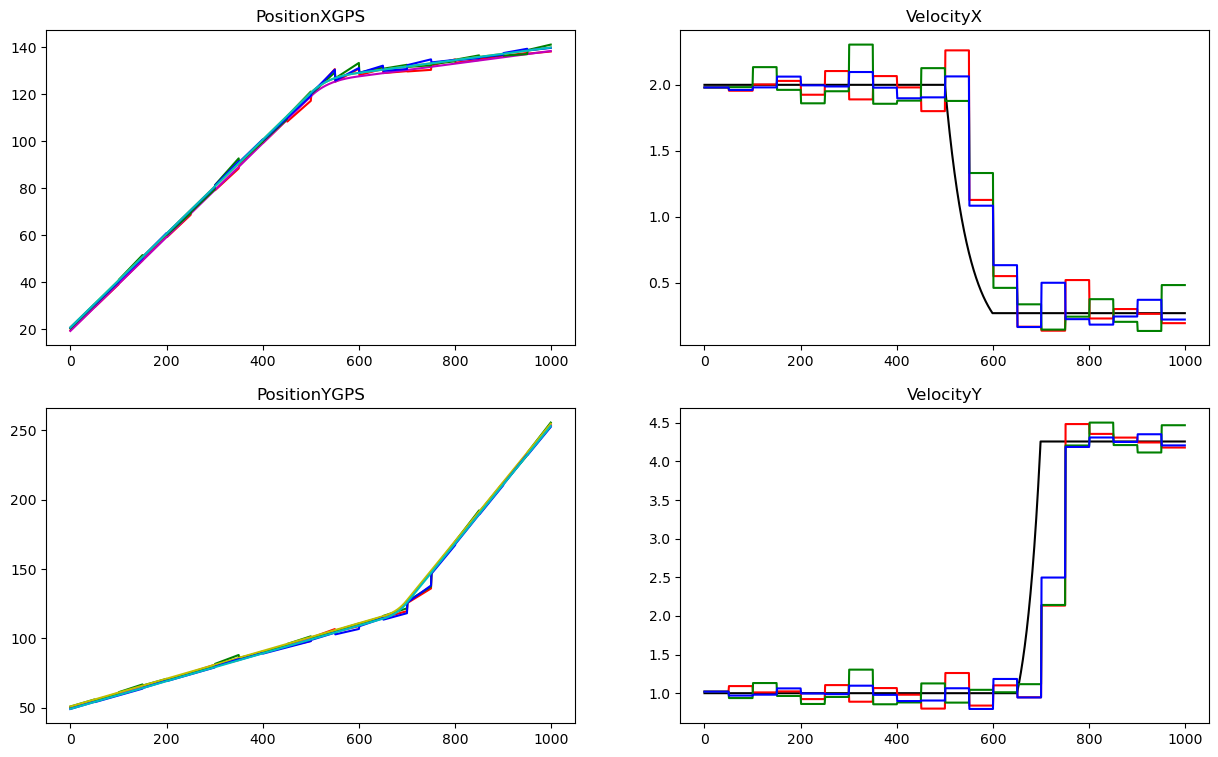

In [3]:
plt.ion()
plt.figure(figsize=(15,9))

real_x = np.array([[20],[50]])
real_xgps1 = np.array([[-1],[0]]) + real_x
real_xgps2 = np.array([[+0.5],[0.8660]]) + real_x
real_xgps3 = np.array([[0.5],[-0.8660]]) + real_x


sigma_meas = 0.2

meas_variance = np.array([[sigma_meas,0],[0,sigma_meas]])
real_v = np.array([[2],[1]])

kf1 = KF(initial_x=np.array([[19.45],[49.74]]), 
        initial_v=np.array([[1.98],[1.02]]), 
        accel_variance=0.2)
kf2 = KF(initial_x=np.array([[20.3],[50.91]]), 
        initial_v=np.array([[1.98],[1.02]]), 
        accel_variance=0.2)
kf3 = KF(initial_x=np.array([[20.6],[49.20]]), 
        initial_v=np.array([[1.98],[1.02]]), 
        accel_variance=0.2)

time_steps = 0.1
num_steps = 1000
meas_steps = 50

mus1 = []
covs1 = []
real_xs1 = []
mus2 = []
covs2 = []
real_xs2 = []
mus3 = []
covs3 = []
real_xs3 = []
real_vs = []


for step in range(num_steps):
    
    if step>500 and step<600:
        real_v = (np.array([[0.98,0],[0,1]])).dot(real_v)
    if step>650 and step<700:
        real_v = (np.array([[1,0],[0,1.03]])).dot(real_v)
          
    covs1.append(kf1.cov)
    mus1.append(kf1.mean)
    covs2.append(kf2.cov)
    mus2.append(kf2.mean)
    covs3.append(kf3.cov)
    mus3.append(kf3.mean)

    real_xgps1 = real_xgps1 + time_steps * real_v
    real_xgps2 = real_xgps2 + time_steps * real_v
    real_xgps3 = real_xgps3 + time_steps * real_v

    kf1.predict(dt=time_steps)
    kf2.predict(dt=time_steps)
    kf3.predict(dt=time_steps)
    
    if step != 0 and step % meas_steps == 0:
        kf1.update(meas_value=real_xgps1 + np.random.randn() * np.sqrt(sigma_meas),
                  meas_variance=meas_variance)
        kf2.update(meas_value=real_xgps2 + np.random.randn() * np.sqrt(sigma_meas),
                  meas_variance=meas_variance)
        kf3.update(meas_value=real_xgps3 + np.random.randn() * np.sqrt(sigma_meas),
                  meas_variance=meas_variance)
    
    real_xs1.append(real_xgps1)
    real_xs2.append(real_xgps2)
    real_xs3.append(real_xgps3)
    real_vs.append(real_v)
    
real_xs1 = np.array(real_xs1)
real_xs2 = np.array(real_xs2)
real_xs3 = np.array(real_xs3)
real_vs = np.array(real_vs)
    
plt.subplot(2, 2, 1)
plt.title('PositionXGPS')
plt.plot([mu[0] for mu in mus1], 'r')
plt.plot(real_xs1[:,0], 'm')
plt.plot([mu[0] for mu in mus2], 'g')
plt.plot(real_xs2[:,0], 'y')
plt.plot([mu[0] for mu in mus3], 'b')
plt.plot(real_xs3[:,0], 'c')
#plt.plot([mu[0] - 2*np.sqrt(cov[0,0]) for mu, cov in zip(mus,covs)], 'r--')
#plt.plot([mu[0] + 2*np.sqrt(cov[0,0]) for mu, cov in zip(mus,covs)], 'r--')

plt.subplot(2, 2, 2)
plt.title('VelocityX')
plt.plot(real_vs[:,0], 'k')
plt.plot([mu[2] for mu in mus1], 'r')
plt.plot([mu[2] for mu in mus2], 'g')
plt.plot([mu[2] for mu in mus3], 'b')
#plt.plot([mu[2] - 2*np.sqrt(cov[2,2]) for mu, cov in zip(mus,covs)], 'r--')
#plt.plot([mu[2] + 2*np.sqrt(cov[2,2]) for mu, cov in zip(mus,covs)], 'r--')

plt.subplot(2, 2, 3)
plt.title('PositionYGPS')
plt.plot([mu[1] for mu in mus1], 'r')
plt.plot(real_xs1[:,1], 'm')
plt.plot([mu[1] for mu in mus2], 'g')
plt.plot(real_xs2[:,1], 'y')
plt.plot([mu[1] for mu in mus3], 'b')
plt.plot(real_xs3[:,1], 'c')
#plt.plot([mu[1] - 2*np.sqrt(cov[1,1]) for mu, cov in zip(mus,covs)], 'r--')
#plt.plot([mu[1] + 2*np.sqrt(cov[1,1]) for mu, cov in zip(mus,covs)], 'r--')

plt.subplot(2, 2, 4)
plt.title('VelocityY')
plt.plot(real_vs[:,1], 'k')
plt.plot([mu[3] for mu in mus1], 'r')
plt.plot([mu[3] for mu in mus2], 'g')
plt.plot([mu[3] for mu in mus3], 'b')
#plt.plot([mu[3] - 2*np.sqrt(cov[3,3]) for mu, cov in zip(mus,covs)], 'r--')
#plt.plot([mu[3] + 2*np.sqrt(cov[3,3]) for mu, cov in zip(mus,covs)], 'r--')

In [4]:
real_xgps3

array([[139.99989064],
       [253.1002698 ]])

In [5]:
real_xgps2

array([[139.99989064],
       [254.8322698 ]])

In [6]:
real_xgps1

array([[138.49989064],
       [253.9662698 ]])

In [7]:
iDx = 0
iDy = 1
iVx = 2
iVy = 3
numvars = max(iDx,iDy,iVx,iVy) + 1
F = np.eye(numvars)
dt = 1
F[iDx,iVx] = dt
F[iDy,iVy] = dt

In [8]:
array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

NameError: name 'array' is not defined